In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math



from architectures.DVAE import *

In [2]:
# some constants

LEARNING_RATE = 0.001
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 10
SAVE_SAMPLE_PERIOD = 428

task='TRAIN'
#task='TEST'
PATH='DVAE_test'
SEED=1

In [3]:
trunc_normal= tf.truncated_normal_initializer(stddev=0.02, seed=SEED)
normal = tf.random_normal_initializer(stddev=0.02, seed=SEED)
glorot_normal = tf.glorot_normal_initializer(seed=SEED)

global e_sizes, d_sizes
e_sizes = {'dense_layers':[(1000, False, 1, tf.nn.relu, glorot_normal),
                     (750, 'bn', 1, tf.nn.relu, glorot_normal),
                     (250, False, 1, tf.nn.relu, glorot_normal)],
           'last_layer_weight_init':glorot_normal,
           'z':100,
}
d_sizes = { 'dense_layers':[(250, False, 1, tf.nn.relu, glorot_normal),
                     (750, 'bn', 1, tf.nn.relu, glorot_normal),
                     (1000, False, 1, tf.nn.relu, glorot_normal),],
           'last_layer_weight_init':glorot_normal,
}

In [4]:
def mnist():

    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
    
    X_train = mnist.train.images
    X_train = (X_train>0.5).astype(np.float32)
    
    X_test = mnist.test.images
    X_test = (X_test>0.5).astype(np.float32)

    dim = X_train.shape[1]
    
    tf.reset_default_graph()
    vae = DVAE(dim, e_sizes, d_sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample= SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED, img_height=28, img_width=28 )
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            vae.set_session(sess)
            vae.fit(X_train)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            vae.set_session(sess)
            
        done = False
        while not done:
            
            i = np.random.choice(len(X_test))
            x = X_test[i]
            im = vae.posterior_predictive_sample([x])
            #print('True energy deposit: '+str(np.sum(x))+'\n'+
            #      'HCAL reconstructed energy deposit: '+str(np.sum(reco))+'\n'+
            #      'NN Simulated energy deposit: '+str(np.sum(im)))
            
            plt.subplot(1,2,1)
            
            plt.imshow(x.reshape(
                                28,
                                28),
                                cmap='gray'
                      )
            plt.title('Original')
            plt.axis('off')
            
            plt.subplot(1,2,2)
            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.title('Sampled')
            plt.axis('off')
            
            fig = plt.gcf()
            fig.set_size_inches(20, 10)
            plt.savefig(PATH+'/sample_%d.png' % i,dpi=100)
            plt.show()
            

            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
            
        done = False
        i=0
        while not done:
            
            im = vae.prior_predictive_sample()
            #print('True energy deposit: '+str(np.sum(x))+'\n'+
            #      'HCAL reconstructed energy deposit: '+str(np.sum(reco))+'\n'+
            #      'NN Simulated energy deposit: '+str(np.sum(im)))
            
            

            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.title('Sampled')
            
            fig = plt.gcf()
            fig.set_size_inches(5, 5)
            plt.savefig(PATH+'/sampled_from_dist_%d.png' % i,dpi=100)
            plt.show()
            i+=1
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
            

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

 Training...

 ****** 

Training deep VAE with a total of 55000 samples distributed in batches of size 128

The learning rate set is 0.001, and every 428 iterations a generated sample will be saved to DVAE_test

 ****** 

Epoch: 0
At iteration: 428  -  dt: 0:00:03.011040 - cost: -150.75
Saving a sample...
Epoch: 1
At iteration: 856  -  dt: 0:00:01.893418 - cost: -121.67
Saving a sample...


/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch: 2
At iteration: 1284  -  dt: 0:00:01.862692 - cost: -106.90
Saving a sample...
Epoch: 3
At iteration: 1712  -  dt: 0:00:01.861169 - cost: -97.09
Saving a sample...
Epoch: 4
At iteration: 2140  -  dt: 0:00:01.858693 - cost: -94.89
Saving a sample...
Epoch: 5
At iteration: 2568  -  dt: 0:00:01.836097 - cost: -102.36
Saving a sample...
Epoch: 6
At iteration: 2996  -  dt: 0:00:01.856693 - cost: -93.34
Saving a sample...
Epoch: 7
At iteration: 3424  -  dt: 0:00:01.816984 - cost: -99.93
Saving a sample...
Epoch: 8
At iteration: 3852  -  dt: 0:00:01.820464 - cost: -95.26
Saving a sample...
Epoch: 9
At iteration: 4280  -  dt: 0:00:01.799732 - cost: -93.63
Saving a sample...


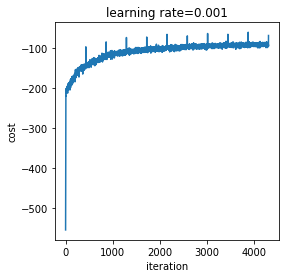

Parameters trained
Model saved in path: DVAE_test/DVAE_test.ckpt


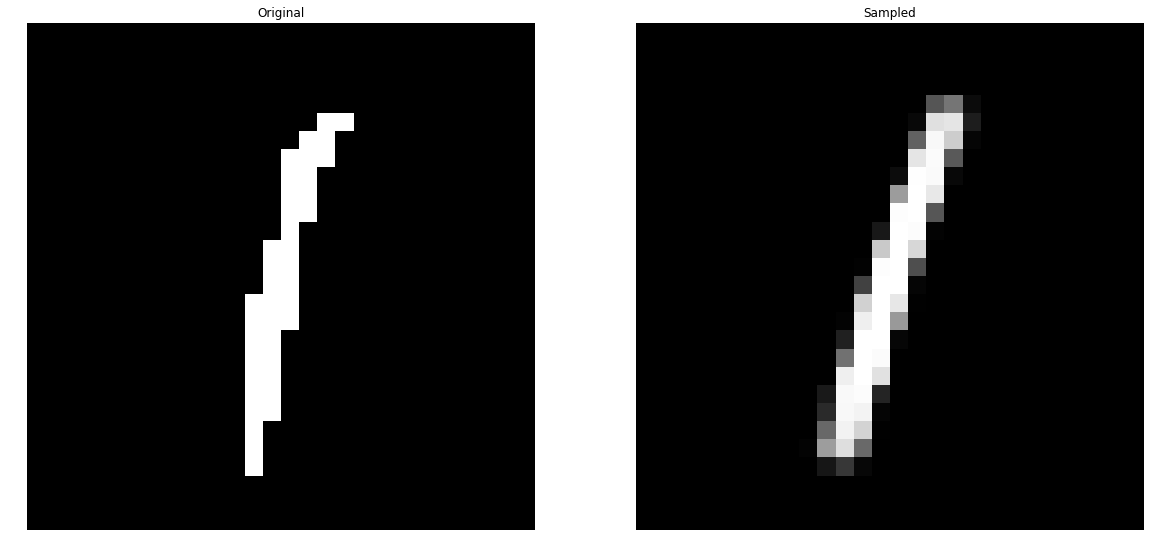

Generate another?


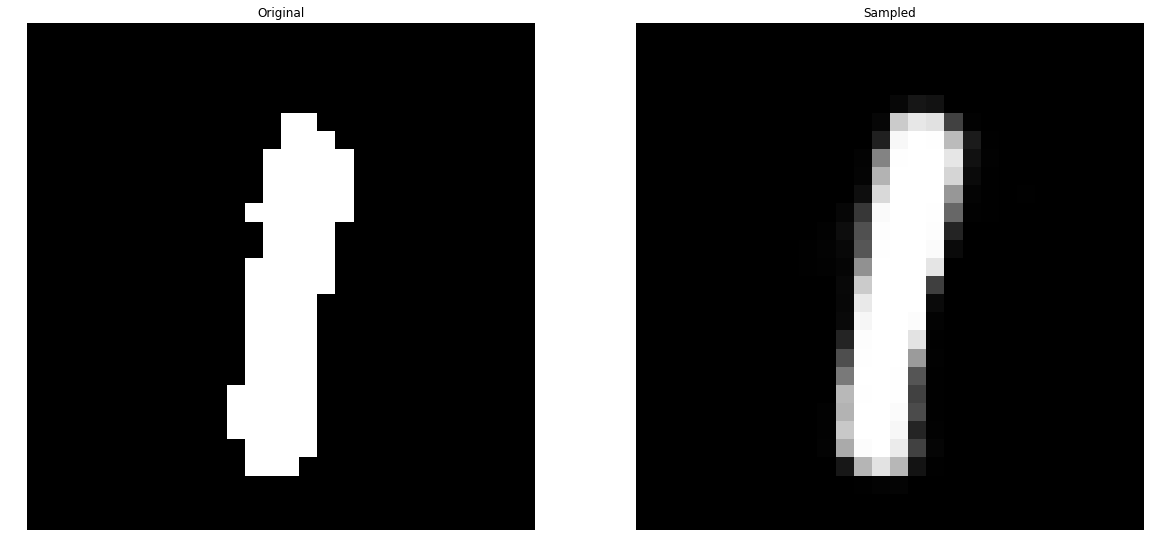

Generate another?


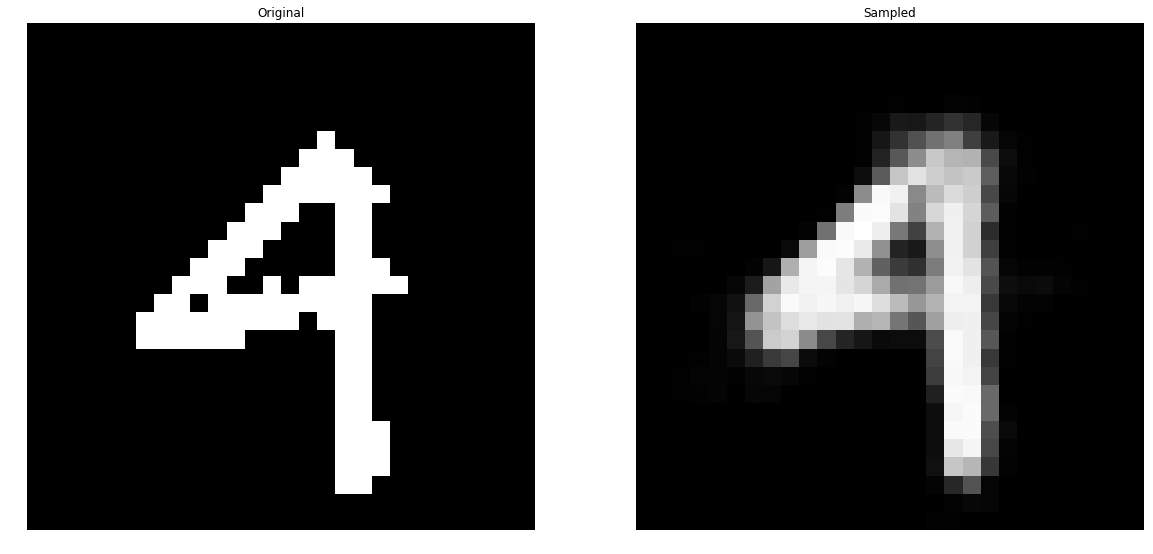

Generate another?


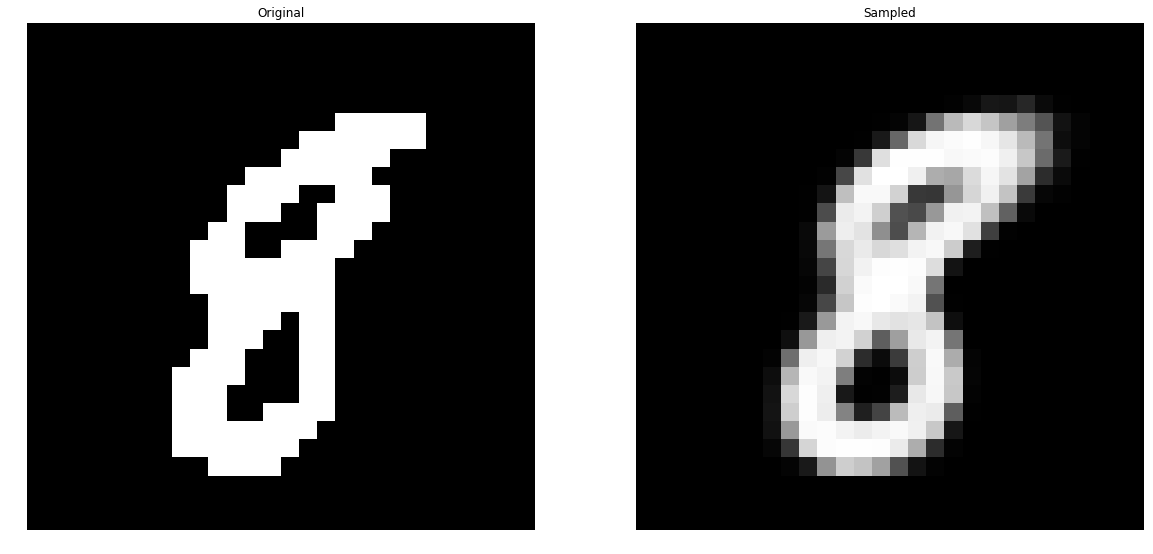

Generate another?


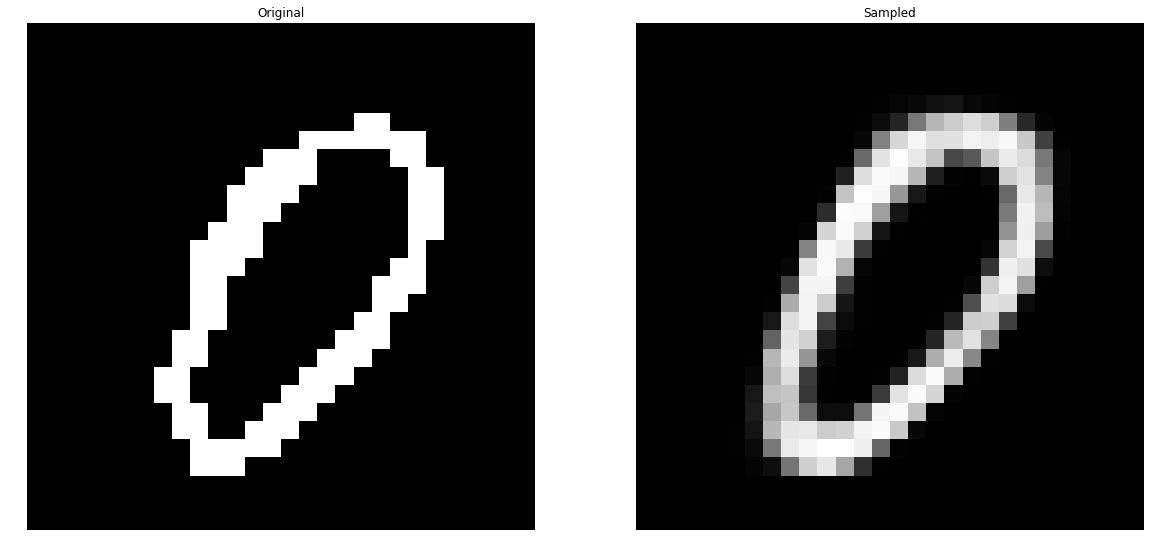

Generate another?


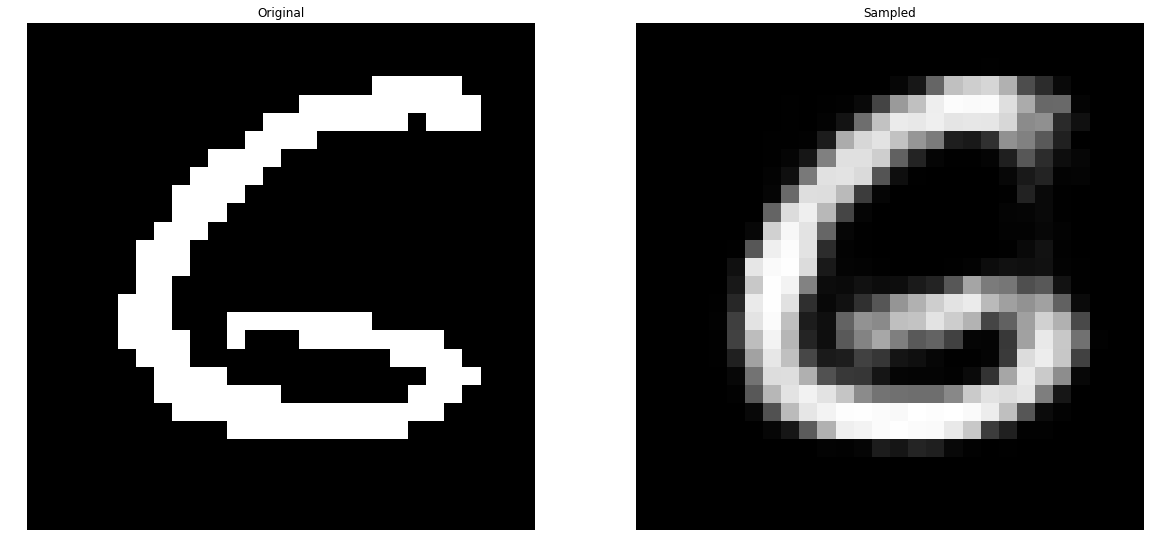

Generate another?


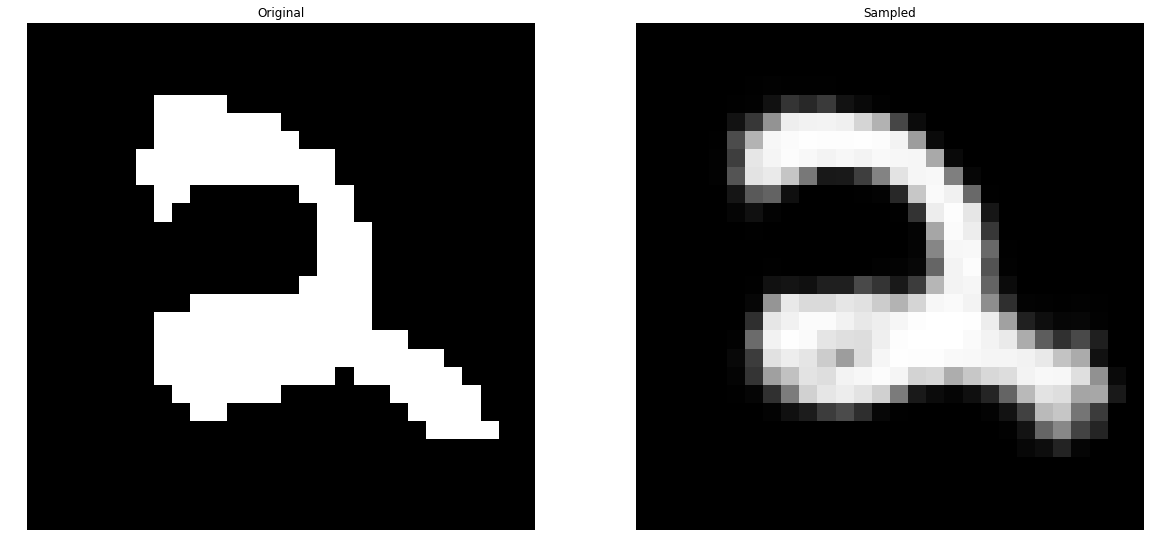

Generate another?


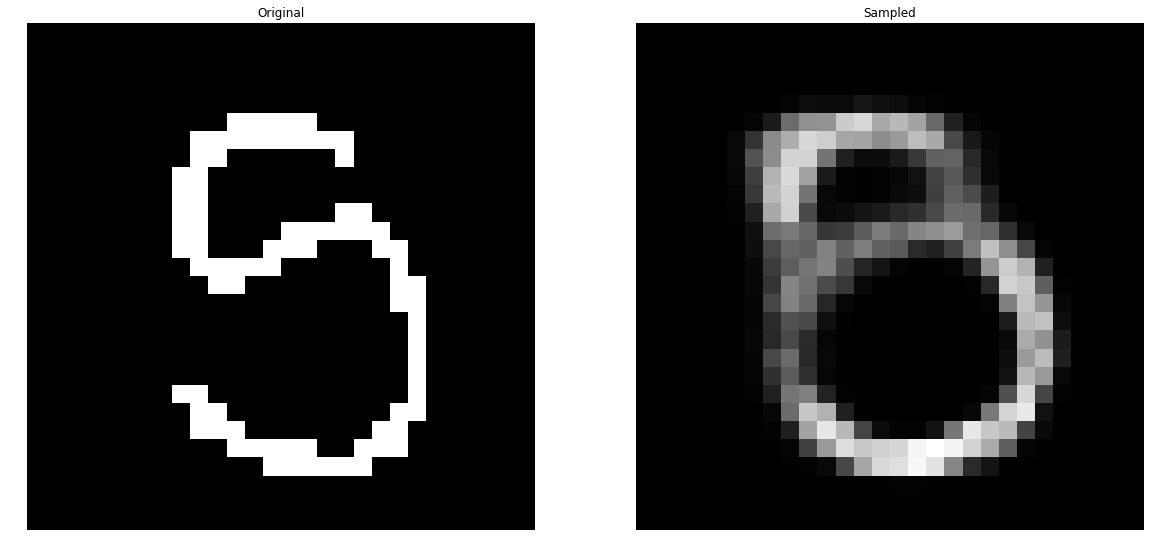

Generate another?


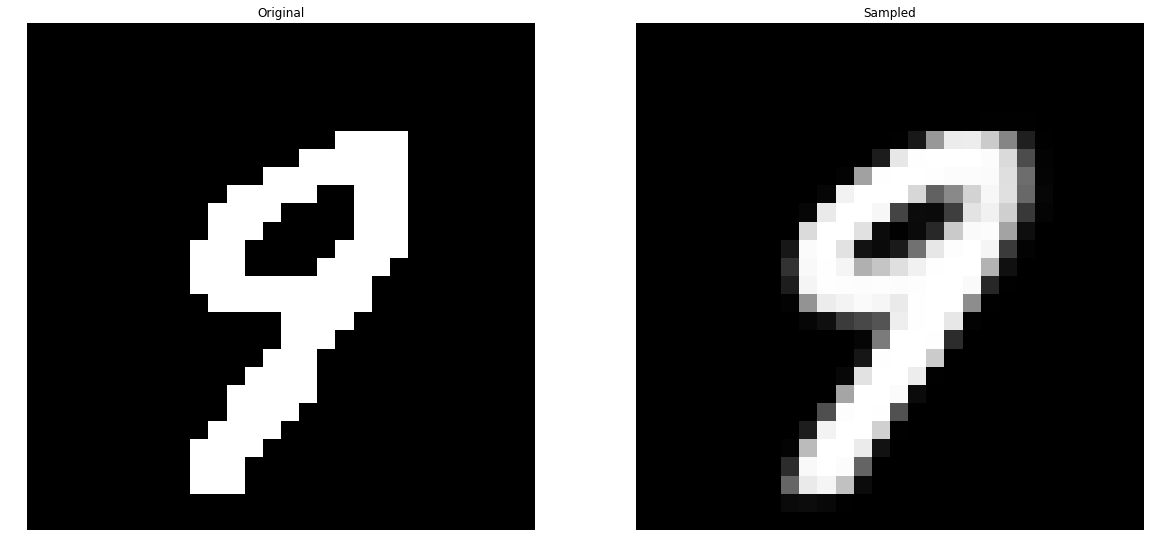

Generate another?n


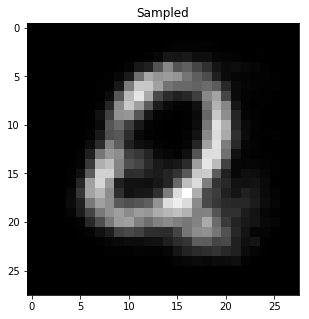

Generate another?


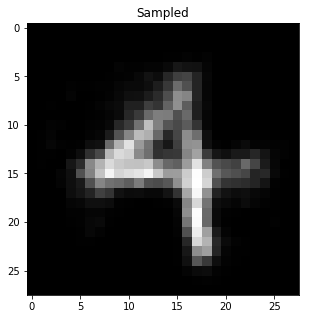

Generate another?


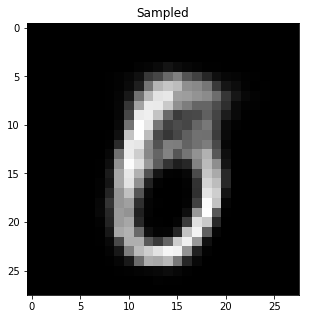

Generate another?


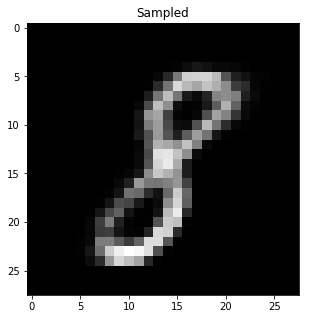

Generate another?


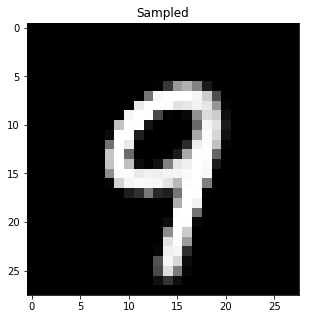

Generate another?


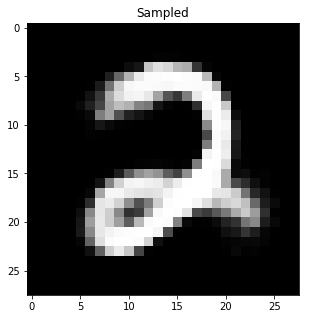

Generate another?


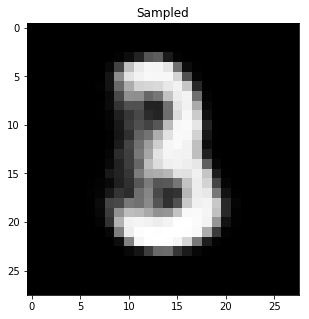

Generate another?


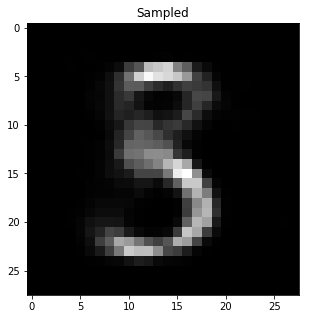

Generate another?


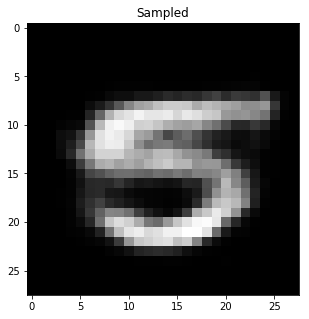

Generate another?n


In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()